In [1]:
import sys
sys.path.insert(0, '/tf/utils/')


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import numpy as np
import os
# Definir o nível de log do TensorFlow para ERROR
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Activation, Dropout, Conv1D, Conv1DTranspose, MaxPooling1D, concatenate, Concatenate, LSTM, Dense, SimpleRNN, BatchNormalization, Dropout, BatchNormalization, Add, Flatten, UpSampling1D, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import LayerNormalization, Dropout, MultiHeadAttention, Conv2D, Conv2DTranspose, MaxPooling2D, Permute, Reshape

# import sounddevice as sd
from scipy.signal import butter, filtfilt
from scipy.signal import resample
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.io import wavfile
from glob2 import glob
from tqdm import tqdm
from pesq import pesq
import matplotlib.pyplot as plt


from utils import load_wav, generate_white_gaussian_noise, add_white_gaussian_noise, undersample_signal_with_antialiasing, somar_sinais, calculate_snr
from sound import Sound

In [3]:
base_shape_size = 2000

In [4]:
sound_base = Sound('./Base/', './ESC-50-master/audio/', base_shape_size)

Loading noise files: 100%|█████████████████| 2000/2000 [00:08<00:00, 234.77it/s]


In [5]:
def calcular_componentes_fourier(sinal):
    if len(sinal.shape) == 3 and sinal.shape[2] == 1:
        sinal = sinal.reshape(sinal.shape[0], sinal.shape[1])

    componentes = np.fft.fft(sinal)
    # Obter a magnitude máxima dos componentes
    # max_magnitude = np.max(np.abs(componentes), axis=1).reshape(-1, 1)
    # Normalizar os componentes para o intervalo [-1, 1]
    max_magnitude = 1
    # componentes_normalizados = componentes / max_magnitude
    res = np.stack((np.real(componentes), np.imag(componentes)), axis=-1)

    return np.array(res), max_magnitude

def reconstruir_sinal(componentes, max_magnitude):
    comp = componentes[:, :, 0] + 1j * componentes[:, :, 1]
#     print(comp.shape)
    sinal_reconstruido = np.fft.ifft(comp) * max_magnitude
    return np.real(sinal_reconstruido)

In [16]:
# model = load_model('refinado_na_pesq_4p0e-5.h5')
model = load_model('epoch-1-refinado_na_pesq.h5')

In [17]:
sound = load_wav('./Base/BR_00400/balsen3_clean.wav')
noise = load_wav('./ESC-50-master/audio/1-7456-A-13.wav')

In [18]:
noisy_sound = somar_sinais(sound, noise[:sound.shape[0]], 10)
noisy_sound = add_white_gaussian_noise(noisy_sound, 10)
noisy_sound = np.clip(noisy_sound, -1, 1)

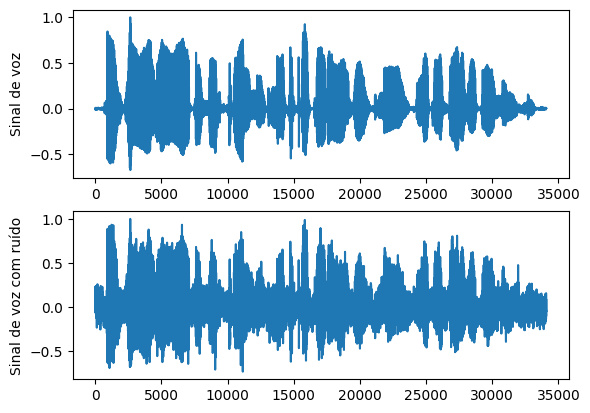

In [19]:
# Criando figuras e eixos separados para cada array
fig, (ax1, ax2) = plt.subplots(2, 1)

# Plotando o primeiro array
ax1.plot(sound)
ax1.set_ylabel('Sinal de voz')

# Plotando o segundo array
ax2.plot(noisy_sound)
ax2.set_ylabel('Sinal de voz com ruído')

# Exibindo os gráficos
plt.show()

In [20]:
comp, _ = calcular_componentes_fourier(noisy_sound[:len(noisy_sound) // base_shape_size * base_shape_size].reshape(-1, base_shape_size))
original_sound, _ = calcular_componentes_fourier(sound[:len(sound) // base_shape_size * base_shape_size].reshape(-1, base_shape_size))

In [21]:
original_sound = original_sound.reshape((-1, base_shape_size, 2))
distorted_sound = comp.reshape((-1, base_shape_size, 2))

In [22]:
filtered = model.predict(distorted_sound.reshape(-1, base_shape_size, 2))

1/1 [==============================] - 1s 746ms/step


In [23]:
filtered_sound = reconstruir_sinal(filtered, 1)

In [24]:
sound_base.save_sound_to_wav(sound.reshape(-1), 'original.wav')
sound_base.save_sound_to_wav(noisy_sound.reshape(-1), 'ruidoso.wav')
sound_base.save_sound_to_wav(filtered_sound.reshape(-1), 'filtrado.wav')

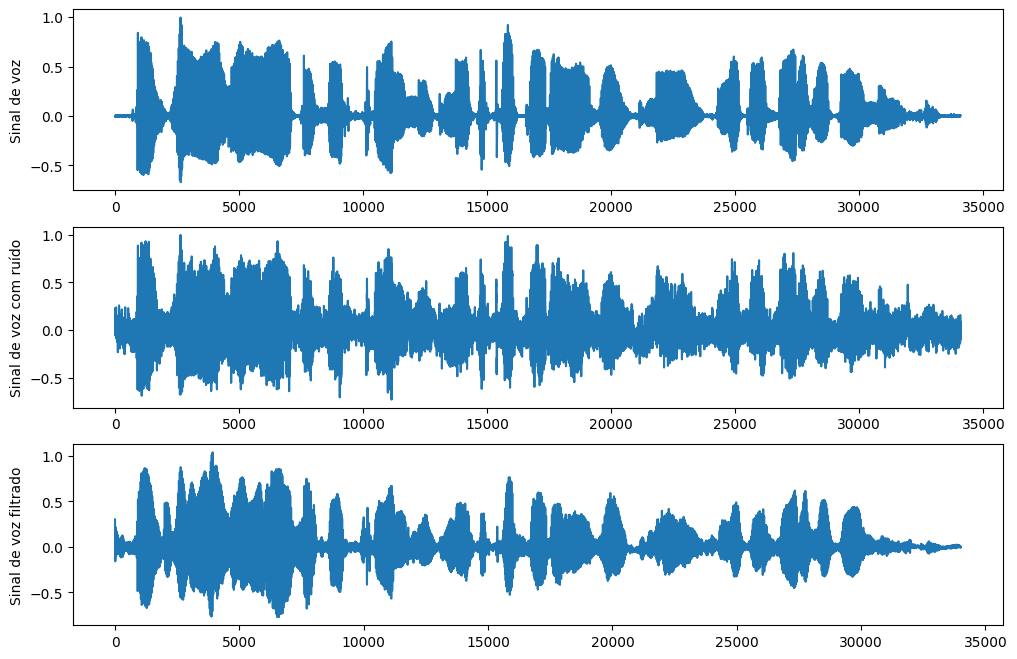

In [25]:
# Criando figuras e eixos separados para cada array
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8))

# Plotando o primeiro array
ax1.plot(sound.reshape(-1))
ax1.set_ylabel('Sinal de voz')

# Plotando o segundo array
ax2.plot(noisy_sound.reshape(-1))
ax2.set_ylabel('Sinal de voz com ruído')

# Plotando o segundo array
ax3.plot(filtered_sound.reshape(-1))
ax3.set_ylabel('Sinal de voz filtrado')

# Exibindo os gráficos
plt.show()